## Import Magic and Modules

In [ ]:
%matplotlib inline

**Possibly Needed Modules**

In [369]:
#sys.path.append('./.local/lib/python3.7/site-packages')
#import os
#import string
#import datetime
#from numpy import loadtxt

**Needed Modules**

In [1]:
import sys
import pandas as pd
import csv
import numpy as np
import math
import scipy.stats as stats
import xgboost as xgb
import glob
import time
import ciso8601

import sqlite3
from datetime import datetime
from datetime import timedelta
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
import seaborn as sns
from matplotlib.pylab import rcParams
import joypy
from matplotlib import cm
import scipy.cluster.hierarchy as shc

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   
from sklearn.model_selection import GridSearchCV   
from sklearn.model_selection import cross_validate

#from numba.typed import List
#from numba import njit

## Be a Good Hobbit and Run the Help Functions

In [2]:
def anchor_help():

    display(Markdown('## Anchor Data Variable Explanations ## \n'))
    display(Markdown('## =================================================== ## \n'))
    display(Markdown('**rcv_time** = *Time at Which Data Was Recorded by Anchor*  \n  **rssi** = *Signal Strength*  \n  **Badge** = *Badge Number*'))
    display(Markdown('**timestamp** = *Time Used to Determine Which Session???????*  \n  **neighbors** = *Badges that Sending Badge Communicates With*  \n  **Node** = *Anchor Number*'))
    display(Markdown('**p1_neighbors** = *Person 1 Neighbors (Not Really Used)*  \n  **p2_neighbors** = *Person 2 Neighbors (Not Really Used)*  \n  **session_id** = *Session in Timeclock File That Row Corresponds To*'))

In [3]:
def timeclock_help():

    display(Markdown('## Timeclock Data Variable Explanations ## \n'))
    display(Markdown('## =================================================== ## \n'))
    display(Markdown('**type** = *Not Sure of Its Use LOL*  \n  **session_id** = *Can Be Used to Join Dataframes (But I Went Another Route)*  \n  **start** = *Session Start Time*'))
    display(Markdown('**stop** = *Session Stop Time*  \n  **annotation** = *Actually Useless*  \n  **Badge IDs** = *Numeric Tags for Badges*'))
    display(Markdown('**Badge Neighbors** = *Other Badges Current Badge Communicates With*  \n  **Badge Locations** = *Where People are Wearing Badges on Their Bodies*  \n  **Badge Annotations** = *Badge Orientations Toward Each Other*  \n  **Distance** = *Distance Apart Badges Are in Inches*'))

## Set Pandas Dataframe Output Parameters

In [4]:
pd.options.display.max_columns = None
pd.options.display.width       = None
pd.set_option('display.max_rows', 20)
pd.set_option("display.precision", 4)
warnings.filterwarnings('ignore')

**Running the Help Function. You should do this if you want Gandalf to come to your birthday party.**

In [5]:
anchor_help()

## Anchor Data Variable Explanations ## 


## =================================================== ## 


**rcv_time** = *Time at Which Data Was Recorded by Anchor*  
  **rssi** = *Signal Strength*  
  **Badge** = *Badge Number*

**timestamp** = *Time Used to Determine Which Session???????*  
  **neighbors** = *Badges that Sending Badge Communicates With*  
  **Node** = *Anchor Number*

**p1_neighbors** = *Person 1 Neighbors (Not Really Used)*  
  **p2_neighbors** = *Person 2 Neighbors (Not Really Used)*  
  **session_id** = *Session in Timeclock File That Row Corresponds To*

In [6]:
timeclock_help()

## Timeclock Data Variable Explanations ## 


## =================================================== ## 


**type** = *Not Sure of Its Use LOL*  
  **session_id** = *Can Be Used to Join Dataframes (But I Went Another Route)*  
  **start** = *Session Start Time*

**stop** = *Session Stop Time*  
  **annotation** = *Actually Useless*  
  **Badge IDs** = *Numeric Tags for Badges*

**Badge Neighbors** = *Other Badges Current Badge Communicates With*  
  **Badge Locations** = *Where People are Wearing Badges on Their Bodies*  
  **Badge Annotations** = *Badge Orientations Toward Each Other*  
  **Distance** = *Distance Apart Badges Are in Inches*

## Anchor Node Input Stuff
## =============================================================

**Read all anchor csv files into Pandas dataframes.**

In [7]:
list_of_files = glob.glob("sdcard" + "*.csv")     # Anchor data filenames
df_names = []

# Append names of files to df_names
for i in range(len(list_of_files)):
    df_names.append("df_" + str(list_of_files[i]))

# Create a list of Pandas dataframes, one for each csv file
list_of_dfs = {}
for df, file in zip(df_names, list_of_files):
    list_of_dfs[df] = pd.read_csv(file)

list_of_dfs["df_sdcard1026_20201125.csv"].drop(list_of_dfs["df_sdcard1026_20201125.csv"].tail(1).index,inplace=True)

for i in range(len(list_of_dfs)):
    list_of_dfs["df_" + str(list_of_files[i])]["sdcard_filename"] = list_of_files[i]
    
list_of_files

['sdcard1029_20201216.csv',
 'sdcard1029_20201125.csv',
 'sdcard1024_20201216.csv',
 'sdcard1026_20201125.csv',
 'sdcard1024_20201125.csv',
 'sdcard1029_20210108.csv',
 'sdcard1024_20210108.csv',
 'sdcard1026_20210108.csv']

**Concatenate all dataframes into single one.**

In [8]:
all_dfs = pd.concat(list_of_dfs, ignore_index=True)
#all_dfs

**Important Variables to Use in Anchor Data Parsing**

In [9]:
anchor_nums = all_dfs["node"].tolist()
anchor_nums = [i.split(" ", 1)[1] for i in anchor_nums]
anchor_nums = list(set([int(i) for i in anchor_nums]))

badge_nums = list(set(all_dfs["badge"]))

session_ids = list(set(all_dfs["session_id"]))

**Copy the previus dataframe into a new dataframe just for safety.**

In [10]:
df_copy = all_dfs.copy()

**Find out the rows of the dataframe where there were multiple communications between the sending badge and an anchor/receiving badges.**

In [11]:
multiple_comms = df_copy["neighbors"].map(lambda x: str(x).count(":")) > 0     # Find out which rows of dataframe have multiple communications
number_comms = df_copy["neighbors"].map(lambda x: str(x).count(":"))           # Count the number of communications for each row
df_multiple = df_copy[multiple_comms]                                          # Create a dataframe that contains only rows where multiple comms occurred
df_multiple = df_multiple.reset_index(drop=True)                               # Reset index

**Create a new dataframe "super_copy" that creates new duplicate rows based on the number of communications seen in a previous row.**

**For example, if one sending badge communicates with an anchor and two receiving badges, then the number of duplicate rows for that signal would be three (one for the communication with the anchor and one for each message to a receiving badge.)**

In [12]:
k = 0
super_copy = []
super_copy.append(df_copy)

# Create a new row each time there is more than one communication between a sending and receiving badge
# It is much faster to create a list of dataframe rows than to keep concatenating dataframes together
for i in range(len(number_comms)):
    if number_comms[i] > 0:
        for j in range(number_comms[i]):
            super_copy.append(df_multiple.iloc[[k]])
        
        k += 1

# Concatenate list of dataframe rows into single dataframe
super_copy = pd.concat(super_copy, axis=0)

# Reformat anchor label (Example: NODE 1026 becomes simply 1026)
x = super_copy["node"].tolist()
x = [i.split(" ", 1)[1] for i in x]
x = [int(i) for i in x] 
super_copy = super_copy.assign(node=x)

**Now sort the dataframe "super_copy" by timestamp AND node number.**

In [13]:
super_copy = super_copy.sort_values(["timestamp", "node"], ascending=[True, True])
super_copy = super_copy.reset_index(drop=True)

**Create "df_copy_2" for use as an intermediate dataframe.**

In [14]:
df_copy_2 = super_copy.copy()
#df_copy_2

**This massive "for" loop reformats the entire dataframe so that each row now corresponds to only one message from one badge
to one anchor or from one badge to another badge.**

In [15]:
counter = 0
switch = 0

for i in range(0, len(super_copy)):
    
    if i != len(super_copy)-1:
        
        if (((super_copy["rssi"][i] == super_copy["rssi"][i+1]) and 
             (super_copy["timestamp"][i] == super_copy["timestamp"][i+1]) 
             and (super_copy["badge"][i] == super_copy["badge"][i+1]) and
            (super_copy["node"][i] == super_copy["node"][i+1]))
            and switch == 0):

            df_copy_2.at[i, "neighbors"] = np.nan
            switch = 1
            continue

        elif (i >= 1 and ((super_copy["rssi"][i] == super_copy["rssi"][i-1]) and 
             (super_copy["timestamp"][i] == super_copy["timestamp"][i-1]) 
             and (super_copy["badge"][i] == super_copy["badge"][i-1]) and (super_copy["node"][i] == super_copy["node"][i-1])) and
            ((super_copy["rssi"][i] == super_copy["rssi"][i+1]) and 
             (super_copy["timestamp"][i] == super_copy["timestamp"][i+1]) 
             and (super_copy["badge"][i] == super_copy["badge"][i+1]) and (super_copy["node"][i] == super_copy["node"][i+1]))):

            y = super_copy.iloc[[i]].at[i, "neighbors"]
            list_of_vals = y.split(" ")
            target = list_of_vals.pop(counter)
            target = target.replace(":", " ")
            target = target.replace("[", "")
            target = target.replace("]", "")
            target = target.split(" ")
            df_copy_2.at[i, "neighbors"] = target[0]
            df_copy_2.at[i, "rssi"] = target[1]
            counter += 1
            continue
        
    if (i >= 1 and ((super_copy["rssi"][i] == super_copy["rssi"][i-1]) and 
         (super_copy["timestamp"][i] == super_copy["timestamp"][i-1]) 
        and (super_copy["badge"][i] == super_copy["badge"][i-1]) and (super_copy["node"][i] == super_copy["node"][i-1]))):
        
        y = super_copy.iloc[[i]].at[i, "neighbors"]
        list_of_vals = y.split(" ")
        target = list_of_vals.pop(counter)
        target = target.replace(":", " ")
        target = target.replace("[", "")
        target = target.replace("]", "")
        target = target.split(" ")
        df_copy_2.at[i, "neighbors"] = target[0]
        df_copy_2.at[i, "rssi"] = target[1]
        counter = 0
        switch = 0
    
    else:
        
        counter = 0
        y = super_copy.iloc[[i]].at[i, "neighbors"]
        
        if type(y) == float and math.isnan(y):
            continue

        target = y.replace(":", " ")
        target = target.replace("[", "")
        target = target.replace("]", "")
        target = target.split(" ")
        df_copy_2.at[i, "neighbors"] = target[0]
        df_copy_2.at[i, "rssi"] = target[1]

**Now we create the final dataframe of reformated anchor data. This will be called "anchor_data."**

In [16]:
# First create a new dataframe that will split timestamps and create timestamps
# that are formatted correctly for future use
new_df                             = pd.DataFrame(df_copy_2["timestamp"])
new_df[["datetime", "extraneous"]] = new_df.timestamp.str.split("+", expand = True)
new_df                             = new_df.drop("extraneous", 1)
new_df                             = new_df.drop("timestamp", 1)
new_df["timestamp"]                = pd.to_datetime(new_df["datetime"], format='%Y-%m-%d %H:%M:%S')

# Now create the final dataframe
anchor_data                        = pd.DataFrame(new_df["timestamp"])
anchor_data["rssi"]                = df_copy_2["rssi"].astype(int)
anchor_data["anchor"]              = df_copy_2["node"].astype(int)
anchor_data["sending_badge"]       = df_copy_2["badge"].astype(int)
anchor_data["receiving_badge"]     = df_copy_2["neighbors"]
anchor_data["session_id_anchor"]   = df_copy_2["session_id"].astype(int)
anchor_data["sdcard_filename"]     = df_copy_2["sdcard_filename"]

anchor_data["receiving_badge"].fillna(anchor_data["anchor"], inplace=True)
anchor_data["receiving_badge"]     = anchor_data["receiving_badge"].astype(int)
#anchor_data["receiving_badge"].fillna(0, inplace=True)

**Split the "anchor_data" dataframe into two separate dataframes.**

**good_anchor_data = data containing legitimate sending and receiving badge numbers** \
**bad_anchor_data  = data containing illegal sending and receiving badge numbers**

In [17]:
good_anchor_data = anchor_data.copy()
good_anchor_data = good_anchor_data[(good_anchor_data["receiving_badge"].isin(badge_nums)) | (good_anchor_data["receiving_badge"].isin(anchor_nums))]  
good_anchor_data = good_anchor_data[good_anchor_data["sending_badge"].isin(badge_nums)]
good_anchor_data

,timestamp,rssi,anchor,sending_badge,receiving_badge,session_id_anchor,sdcard_filename
0,2020-11-25 21:58:02,172,1024,2,1024,1,sdcard1024_20201125.csv
1,2020-11-25 21:58:02,195,1024,2,4,1,sdcard1024_20201125.csv
2,2020-11-25 21:58:02,175,1026,2,1026,1,sdcard1026_20201125.csv
3,2020-11-25 21:58:02,195,1026,2,4,1,sdcard1026_20201125.csv
4,2020-11-25 21:58:02,173,1029,2,1029,1,sdcard1029_20201125.csv
...,...,...,...,...,...,...,...
69259,2021-01-08 22:57:04,179,1024,2,1024,20,sdcard1024_20210108.csv
69260,2021-01-08 22:57:04,174,1024,4,1024,20,sdcard1024_20210108.csv
69261,2021-01-08 22:57:04,161,1026,2,1026,20,sdcard1026_20210108.csv
69262,2021-01-08 22:57:04,184,1026,4,1026,20,sdcard1026_20210108.csv


In [18]:
bad_anchor_data = anchor_data.copy()
bad_anchor_data = bad_anchor_data[~(bad_anchor_data["receiving_badge"].isin(badge_nums)) & ~(bad_anchor_data["receiving_badge"].isin(anchor_nums))]  
#bad_anchor_data = bad_anchor_data[~(bad_anchor_data["sending_badge"].isin(badge_nums))]
bad_anchor_data

,timestamp,rssi,anchor,sending_badge,receiving_badge,session_id_anchor,sdcard_filename


## Distance Data Stuff
## =============================================================

**Read in the data from the "timeclock.csv" file.**

In [19]:
list_of_distance_files = glob.glob("timeclock" + "*.csv")

df_distance_names = []

for i in range(len(list_of_distance_files)):
    df_distance_names.append("df_" + str(list_of_distance_files[i]))

list_of_distance_dfs = {}

for df, file in zip(df_distance_names, list_of_distance_files):
    list_of_distance_dfs[df] = pd.read_csv(file)

sizes = []

for i in range(len(list_of_distance_files)):
    list_of_distance_dfs["df_" + str(list_of_distance_files[i])]["timeclock_filename"] = list_of_distance_files[i]
    sizes.append(list_of_distance_dfs["df_" + str(list_of_distance_files[i])].shape[0])

df_distances = pd.concat(list_of_distance_dfs, ignore_index=True)
list_of_distance_files

['timeclock_2020-12-16.csv',
 'timeclock_2021-01-08.csv',
 'timeclock_2020-11-25.csv']

**Reorder Session IDs So That There Are No Duplicates**

In [20]:
counter = 0

for i in range(df_distances.shape[0]):
    
    if df_distances["type"][i] == "START":
        df_distances.at[i, "session_id"] = counter
        counter += 1
    else:
        df_distances.at[i, "session_id"] = counter   

**Decrement Some Badge Numbers (Probably Not a Good Idea)**

In [21]:
#k = -(df_distances["p1badge1_id"] > 7).astype(int)
#df_distances["p1badge1_id"] = df_distances["p1badge1_id"] + k

#k = -(df_distances["p1badge2_id"] > 7).astype(int)
#df_distances["p1badge2_id"] = df_distances["p1badge2_id"] + k
#df_distances

In [22]:
# Reformt the date and time so that it can be used when I join dataframes
# Here are the start date and time
df                        = pd.DataFrame(df_distances["start"])
df[["new", "extraneous"]] = df.start.str.split("+", expand = True)
df                        = df.drop("extraneous", 1)
df                        = df.drop("start", 1)
df["start"]               = pd.to_datetime(df["new"], format='%Y-%m-%d %H:%M:%S')
df_distances              = df_distances.assign(start = df["start"])

# Here are the end date and time
df                        = pd.DataFrame(df_distances["stop"])
df[["new", "extraneous"]] = df.stop.str.split("+", expand = True)
df                        = df.drop("extraneous", 1)
df                        = df.drop("stop", 1)
df["stop"]                = pd.to_datetime(df["new"], format='%Y-%m-%d %H:%M:%S')
df_distances              = df_distances.assign(stop = df["stop"])

df_distances              = df_distances.rename(columns={"session_id": "session_id_distances"})
#del df_distances["session_id_distances"]
#del df_distances["start"]
#del df_distances["stop"]

df_distances["distance"]             = df_distances["distance"].astype(int)
df_distances["session_id_distances"] = df_distances["session_id_distances"].astype(int)
df_distances["p1badge1_id"]          = df_distances["p1badge1_id"].astype(int)
df_distances["p1badge2_id"]          = df_distances["p1badge2_id"].astype(int)
df_distances["p2badge1_id"]          = df_distances["p2badge1_id"].astype(int)
df_distances["p2badge2_id"]          = df_distances["p2badge2_id"].astype(int)

**Add in Missing Times for "Events" Such As Stopping at Doors**

In [23]:
types            = np.array(df_distances["type"])
counter          = 0
df_new_distances = df_distances.copy()
vals_to_drop     = []

for i in range(df_distances.shape[0]):
    
    ts1 = ciso8601.parse_datetime(str(df_distances["start"][i]))
    ts1 = time.mktime(ts1.timetuple())
        
    if i != (df_distances.shape[0] - 1):
        ts2 = ciso8601.parse_datetime(str(df_distances["start"][i + 1]))
        ts2 = time.mktime(ts2.timetuple())
    
    if (types[i] == "EVENT") and (i == df_distances.shape[0] - 1):
        df_distances.at[i, "stop"] = df_distances["start"][i] + timedelta(seconds = 500)
        
    elif types[i] == "EVENT":
        df_distances.at[i, "stop"] = df_distances["start"][i + 1] - timedelta(milliseconds = 1)
                
    elif (i != df_distances.shape[0] - 1) and (types[i] == "START") and  (types[i + 1] == "EVENT") and abs(ts1 - ts2) < 86400: 
        df_distances.at[i, "stop"] = df_distances["start"][i + 1] - timedelta(milliseconds = 1)
            
    else:
        continue

df_distances = df_distances.drop(vals_to_drop)

## Joining Dataframes using SQLITE
## =============================================================

**Joining dataframes based on timestamps. The anchor data contains specific timestamps while the distance data contains an interval of time. If the timestamp in the anchor data is within the time interval of a row in the distance data, the dataframes are joined at that place.**

In [426]:
conn = sqlite3.connect(':memory:')
good_anchor_data.to_sql('Anchor_Data', conn, index=False)
df_distances.to_sql('Distances', conn, index=False)

qry = '''
    select *
    from
        Anchor_Data join Distances on
        timestamp between start and stop
    '''

#other_data = pd.read_sql_query(qry, conn)

#qry = '''
#        select *
#        from Anchor_Data join Distances
#        on Anchor_Data.session_id_anchor = Distances.session_id_distances
#    '''

truth_data = pd.read_sql_query(qry, conn)
del truth_data["session_id_anchor"]
truth_data = truth_data.rename({"session_id_distances": "session_id"}, axis= "columns")
#truth_data.equals(other_data)

np.set_printoptions(threshold=sys.maxsize)

**Changing Session IDs so that There Are No Duplicates**

**Filtering out Sending and Receiving Objects with Unknown Locations**

In [427]:
badges = [set(df_distances["p1badge1_id"]), set(df_distances["p1badge2_id"]),
                set(df_distances["p2badge1_id"]), set(df_distances["p2badge2_id"])]

known_badges = list(set().union(*badges))

truth_data = truth_data[truth_data["sending_badge"].isin(known_badges)]
truth_data = truth_data[truth_data["receiving_badge"].isin(known_badges)]
truth_data = truth_data.reset_index(drop = True)

**Adding Unix Epoch Time Column for the Purpose of Time Series Analysis**

In [428]:
time_series = truth_data["timestamp"]
time_series = list(time_series)
ts          = [0 for j in range(len(time_series))]
unixtime    = [0 for j in range(len(time_series))]

for i in range(len(time_series)):
    
    ts[i]       = ciso8601.parse_datetime(time_series[i])
    unixtime[i] = time.mktime(ts[i].timetuple())
    
truth_data.insert(1, "unix_times", unixtime)

**Putting Rows into Bins Based on Time Data Was Recorded**

In [429]:
truth_data["bin"] = ""
alpha             = 10
start_time        = 0
start_session     = -1
bins              = 0

time_vals         = list(truth_data["unix_times"])
session_vals      = list(truth_data["session_id"])

for i in range(truth_data.shape[0]):
    
    current_time = time_vals[i]
    current_session = session_vals[i]
    session_diff = current_session - start_session
    
    if ((current_time - start_time) > alpha) or session_diff != 0:
        
        start_time              = current_time
        start_session           = current_session
        bins                   += 1
        truth_data.at[i, "bin"] = bins
        continue
        
    else:
        
         truth_data.at[i, "bin"] = bins

**See Whether Badges Are Persistent Senders (i.e., They Send Multiple Messages Within a 20 Second Time Window)**
<br> <br>
**If Persistent, Persistence = 1. If Not Persistent, Persistence = 0**

In [430]:
truth_data["persistence"] = ""
beta                      = 10
sending_badges            = np.array(truth_data["sending_badge"])
time_vals                 = np.array(truth_data["unix_times"])
sending_badges            = np.array(truth_data["sending_badge"])
session_vals              = np.array(truth_data["session_id"])

for i in range(truth_data.shape[0]):
    
    current_time        = time_vals[i]
    current_badge       = sending_badges[i]
    current_session     = session_vals[i]
    lower_bound         = current_time - beta
    upper_bound         = current_time + beta
    times_upper         = (time_vals > current_time) & (time_vals < upper_bound)
    times_lower         = (time_vals > lower_bound) & (time_vals < current_time)
    correct_badge_upper = sum((sending_badges[times_upper] == current_badge) & (session_vals[times_upper] == current_session))
    correct_badge_lower = sum((sending_badges[times_lower] == current_badge) & (session_vals[times_lower] == current_session))
    
    if (correct_badge_upper > 0) and (correct_badge_lower > 0):
        truth_data.at[i, "persistence"] = 1        
    else:
        truth_data.at[i, "persistence"] = 0 

**Add Tag Saying Whether a Message Has a Reciprocal (No = 0 and Yes = 1)**

In [431]:
truth_data["reciprocal"] = ""

sending_badges   = list(truth_data["sending_badge"])
receiving_badges = list(truth_data["receiving_badge"])
bins             = list(truth_data["bin"])
rssis            = list(truth_data["rssi"])
ids              = list(truth_data["session_id"])
present          = 0
counter          = 1

for j in range(1, truth_data["bin"].max() + 1):
    
    last     = present
    present += truth_data[truth_data["bin"] == j].shape[0]

    for i in range(last, present):
        for k in range(last, present):
            
            if ids[i] == ids[k]:
                if (sending_badges[i] == receiving_badges[k]) and (sending_badges[k] == receiving_badges[i]):
                    if np.absolute(rssis[i] - rssis[k]) <= 3:
                        if (truth_data.at[i, "reciprocal"] == "") and (truth_data.at[k, "reciprocal"] == ""):
                            truth_data.at[i, "reciprocal"] = counter
                            truth_data.at[k, "reciprocal"] = counter
                            counter += 1
                        
        if truth_data.at[i, "reciprocal"] == "":
            truth_data.at[i, "reciprocal"] = 0
        

**Redoing Distance for Badges That We Know Are on the Same Person**

In [432]:
person_badge_pairs = [[1, 2], [3, 4], [5, 6], [8, 9], [4, 5]]

truth_data["distance"][(truth_data["sending_badge"].isin(person_badge_pairs[0])) & (truth_data["receiving_badge"].isin(person_badge_pairs[0]))] = 10
truth_data["distance"][(truth_data["sending_badge"].isin(person_badge_pairs[1])) & (truth_data["receiving_badge"].isin(person_badge_pairs[1]))] = 10
truth_data["distance"][(truth_data["sending_badge"].isin(person_badge_pairs[2])) & (truth_data["receiving_badge"].isin(person_badge_pairs[2]))] = 10
truth_data["distance"][(truth_data["sending_badge"].isin(person_badge_pairs[3])) & (truth_data["receiving_badge"].isin(person_badge_pairs[3]))] = 10
truth_data["distance"][(truth_data["sending_badge"].isin(person_badge_pairs[4])) & (truth_data["receiving_badge"].isin(person_badge_pairs[4]))] = 10

#truth_data.to_csv("D:/Hospital Networking/Lots_of_Data.csv", index=False, date_format='%Y-%m-%d %H:%M:%S')  

**Relabelling Incorrectly Labelled Data**

In [433]:
truth_data["p2annotation"][truth_data["p2annotation"] == 'Shelby-sitting; facing '] = 'Shelby-sitting; facing'
truth_data["p1annotation"][truth_data["p1annotation"] == 'Phil-sitting facing'] = 'Phil-sitting; facing'
truth_data["p1annotation"][truth_data["p1annotation"] == 'Phil-sitting; facing '] = 'Phil-sitting; facing'
truth_data["p1annotation"][truth_data["p1annotation"] == 'Phil-facing '] = 'Phil-facing'

**Give Appropriate Locations of Sending and Receiving Badges**

In [434]:
truth_data["sending_badge_loc"] = ""
truth_data["receiving_badge_loc"] = ""

truth_data.loc[(truth_data["sending_badge"] == 1) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "sending_badge_loc"] = "left lapel"
truth_data.loc[(truth_data["sending_badge"] == 1) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "sending_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["sending_badge"] == 2) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "sending_badge_loc"] = "left hip"
truth_data.loc[(truth_data["sending_badge"] == 2) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "sending_badge_loc"] = "right lapel"


truth_data.loc[(truth_data["sending_badge"] == 3) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "sending_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["sending_badge"] == 4) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "sending_badge_loc"] = "left hip"
truth_data.loc[(truth_data["sending_badge"] == 4) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "sending_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["sending_badge"] == 5) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "sending_badge_loc"] = "left lapel"
truth_data.loc[(truth_data["sending_badge"] == 5) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "sending_badge_loc"] = "right lapel"


truth_data.loc[(truth_data["sending_badge"] == 6) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "sending_badge_loc"] = "right lapel"


truth_data.loc[(truth_data["sending_badge"] == 8) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "sending_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["sending_badge"] == 9) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "sending_badge_loc"] = "right lapel"



In [435]:
truth_data.loc[(truth_data["receiving_badge"] == 1) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "receiving_badge_loc"] = "left lapel"
truth_data.loc[(truth_data["receiving_badge"] == 1) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "receiving_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["receiving_badge"] == 2) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "receiving_badge_loc"] = "left hip"
truth_data.loc[(truth_data["receiving_badge"] == 2) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "receiving_badge_loc"] = "right lapel"


truth_data.loc[(truth_data["receiving_badge"] == 3) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "receiving_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["receiving_badge"] == 4) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[2]), "receiving_badge_loc"] = "left hip"
truth_data.loc[(truth_data["receiving_badge"] == 4) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "receiving_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["receiving_badge"] == 5) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "receiving_badge_loc"] = "left lapel"
truth_data.loc[(truth_data["receiving_badge"] == 5) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[1]), "receiving_badge_loc"] = "right lapel"


truth_data.loc[(truth_data["receiving_badge"] == 6) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "receiving_badge_loc"] = "right lapel"


truth_data.loc[(truth_data["receiving_badge"] == 8) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "receiving_badge_loc"] = "left lapel"


truth_data.loc[(truth_data["receiving_badge"] == 9) & 
               (truth_data["timeclock_filename"] == list_of_distance_files[0]), "receiving_badge_loc"] = "right lapel"


truth_data.loc[truth_data["receiving_badge"] > 1000, "receiving_badge_loc"] = "anchor"

**Dropping Undesirable Rows and Columns from the Dataframe**

In [436]:
truth_data.drop(["start", "stop", "type", "session_id", "p1badge2_id",
                "p1badge1_id", "p1badge2_id", "p2badge1_id", "p2badge2_id", "p1badge1_loc", "p1badge2_loc",
                "p2badge1_loc", "p2badge2_loc", "timeclock_filename", "bin", "sdcard_filename"], axis=1, inplace=True)

truth_data = truth_data[~truth_data["receiving_badge"].isin(anchor_nums)]
truth_data = truth_data[truth_data["distance"] != 10]
truth_data["sending_badge_loc"].replace("", np.nan, inplace=True)
truth_data["receiving_badge_loc"].replace("", np.nan, inplace=True)
truth_data.dropna(subset=["sending_badge_loc"], inplace = True)
truth_data.dropna(subset=["receiving_badge_loc"], inplace = True)

**Final Result**

In [437]:
#truth_data.to_csv("D:/Hospital Networking/Lets_Try_This_Again.csv", index=False, date_format='%Y-%m-%d %H:%M:%S')  
truth_data

,timestamp,unix_times,rssi,anchor,sending_badge,receiving_badge,annotation,p1annotation,p2annotation,distance,persistence,reciprocal,sending_badge_loc,receiving_badge_loc
0,2020-11-25 21:58:02,1.6064e+09,195,1024,2,4,None,Phil-facing,Shelby-facing,120,0,1,left hip,left hip
1,2020-11-25 21:58:02,1.6064e+09,195,1026,2,4,None,Phil-facing,Shelby-facing,120,0,2,left hip,left hip
2,2020-11-25 21:58:02,1.6064e+09,195,1029,2,4,None,Phil-facing,Shelby-facing,120,0,3,left hip,left hip
3,2020-11-25 21:58:04,1.6064e+09,193,1024,4,2,None,Phil-facing,Shelby-facing,120,0,1,left hip,left hip
4,2020-11-25 21:58:04,1.6064e+09,193,1026,4,2,None,Phil-facing,Shelby-facing,120,0,2,left hip,left hip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38819,2021-01-08 22:56:45,1.6102e+09,178,1024,1,5,None,Phil-sitting; R shoulder facing,Shelby-sitting; L shoulder facing,108,1,0,left lapel,right lapel
38820,2021-01-08 22:56:45,1.6102e+09,178,1024,1,4,None,Phil-sitting; R shoulder facing,Shelby-sitting; L shoulder facing,108,1,0,left lapel,left lapel
38824,2021-01-08 22:56:45,1.6102e+09,178,1026,1,5,None,Phil-sitting; R shoulder facing,Shelby-sitting; L shoulder facing,108,1,0,left lapel,right lapel
38825,2021-01-08 22:56:45,1.6102e+09,178,1026,1,4,None,Phil-sitting; R shoulder facing,Shelby-sitting; L shoulder facing,108,1,0,left lapel,left lapel


## Truth Data  Analysis
## =============================================================

**Here is a histogram of ALL RSSI values.**

In [438]:
rssis = truth_data["rssi"]

fig, ax = plt.subplots(figsize = (10,10))

rssis.plot(kind = "hist", density = False, alpha = 0.65, bins = 15)
rssis.plot(kind = "kde")

quant_5  = rssis.quantile(0.05)
quant_25 = rssis.quantile(0.25)
quant_50 = rssis.quantile(0.5)
quant_75 = rssis.quantile(0.75)
quant_95 = rssis.quantile(0.95)
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

ax.set_xlabel("RSSI")
x_start, x_end = 140, 220
ax.set_xlim(x_start, x_end)

#ax.set_ylim(0, 1)
#ax.set_yticklabels([])
ax.set_ylabel("Frequency")

# Annotations
ax.text(quant_5-.1, 2000, "5th", size = 10, alpha = 0.8)
ax.text(quant_25-.13, 2500, "25th", size = 11, alpha = 0.85)
ax.text(quant_50-.13, 3000, "50th", size = 12, alpha = 1)
ax.text(quant_75-.13, 3500, "75th", size = 11, alpha = 0.85)
ax.text(quant_95-.25, 4000, "95th Percentile", size = 10, alpha =.8)

ax.grid(False)
ax.set_title("All RSSI Values", size = 17, pad = 10)

ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
    
plt.close()
#plt.show()

**Here are histograms for RSSI values at different distances**

In [130]:
list_of_distances = sorted(list(set(truth_data["distance"])))
print("The number of different distances in inches are:", list_of_distances)

The number of different distances in inches are: [24, 35, 36, 40, 48, 54, 55, 60, 72, 84, 96, 108, 120, 132, 144, 156, 180, 228, 240, 360, 480]


In [44]:
for j in range(len(list_of_distances)):

    distance = truth_data[(truth_data["distance"] == list_of_distances[j])]["rssi"]

    fig, ax = plt.subplots(figsize = (6,4))

    distance.plot(kind = "hist", density = False, alpha = 0.65, bins = 15)
    distance.plot(kind = "kde")

    quant_5  = distance.quantile(0.05)
    quant_25 = distance.quantile(0.25)
    quant_50 = distance.quantile(0.5)
    quant_75 = distance.quantile(0.75)
    quant_95 = distance.quantile(0.95)
    quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

    for i in quants:
        ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    ax.set_xlabel("RSSI")
    x_start, x_end = 140, 220
    ax.set_xlim(x_start, x_end)

    #ax.set_ylim(0, 1)
    #ax.set_yticklabels([])
    ax.set_ylabel("Frequency")

    # Annotations
    #ax.text(quant_5-.1, 200, "5th", size = 10, alpha = 0.8)
    #ax.text(quant_25-.13, 300, "25th", size = 11, alpha = 0.85)
    #ax.text(quant_50-.13, 400, "50th", size = 12, alpha = 1)
    #ax.text(quant_75-.13, 500, "75th", size = 11, alpha = 0.85)
    #ax.text(quant_95-.25, 600, "95th Percentile", size = 10, alpha =.8)

    ax.grid(False)
    ax.set_title("Distance = %.i in." % list_of_distances[j], fontsize = 17, pad = 10)

    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

    plt.close()
   # plt.show()


In [131]:
set(truth_data["p1annotation"])

{'Phil-L shoulder facing',
 'Phil-R shoulder facing',
 'Phil-facing',
 'Phil-facing and swaying',
 'Phil-facing away',
 'Phil-sitting at table with plexiglass; L shoulder facing',
 'Phil-sitting at table with plexiglass; facing',
 'Phil-sitting at table with plexiglass; staggered',
 'Phil-sitting at table without plexiglass; L shoulder facing',
 'Phil-sitting; L shoulder facing',
 'Phil-sitting; R shoulder facing',
 'Phil-sitting; facing',
 'Phil-sitting; facing away',
 'Phil-sitting; staggered facing',
 'Phil-walking'}

In [132]:
set(truth_data["p2annotation"])

{'Shelby-L shoulder facing',
 'Shelby-R shoulder facing',
 'Shelby-facing',
 'Shelby-facing and swaying',
 'Shelby-facing away',
 'Shelby-sitting at table with outplexiglass; R shoulder facing',
 'Shelby-sitting at table with plexiglass; R shoulder facing',
 'Shelby-sitting at table with plexiglass; facing',
 'Shelby-sitting at table with plexiglass; staggered',
 'Shelby-sitting facing',
 'Shelby-sitting; L shoulder facing',
 'Shelby-sitting; R shoulder facing',
 'Shelby-sitting; facing',
 'Shelby-sitting; facing away',
 'Shelby-sitting; staggered facing',
 'Shelby-walking'}

In [439]:
data_to_plot = truth_data.copy()
data_to_plot = truth_data[(truth_data["sending_badge_loc"] == "left lapel")
                          |  (truth_data["sending_badge_loc"] == "right lapel")]

data_to_plot = data_to_plot[(data_to_plot["receiving_badge_loc"] == "left lapel")
                          |  (data_to_plot["receiving_badge_loc"] == "right lapel")]

data_to_plot = data_to_plot[(data_to_plot["p1annotation"] == "Phil-facing") & (data_to_plot["p2annotation"] == "Shelby-facing")]
data_to_plot = data_to_plot[(data_to_plot["reciprocal"] != 0) & (data_to_plot["persistence"] != 0)]
data_to_plot = data_to_plot.reset_index(drop = True)
data_to_plot

,timestamp,unix_times,rssi,anchor,sending_badge,receiving_badge,annotation,p1annotation,p2annotation,distance,persistence,reciprocal,sending_badge_loc,receiving_badge_loc
0,2020-11-25 21:59:42,1.6064e+09,190,1024,3,1,None,Phil-facing,Shelby-facing,120,1,70,left lapel,left lapel
1,2020-11-25 21:59:42,1.6064e+09,190,1026,3,1,None,Phil-facing,Shelby-facing,120,1,71,left lapel,left lapel
2,2020-11-25 21:59:42,1.6064e+09,190,1029,3,1,None,Phil-facing,Shelby-facing,120,1,72,left lapel,left lapel
3,2020-11-25 21:59:53,1.6064e+09,192,1024,1,3,None,Phil-facing,Shelby-facing,120,1,86,left lapel,left lapel
4,2020-11-25 21:59:53,1.6064e+09,192,1026,1,3,None,Phil-facing,Shelby-facing,120,1,90,left lapel,left lapel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,2020-12-16 23:49:37,1.6082e+09,196,1029,6,8,None,Phil-facing,Shelby-facing,240,1,8473,right lapel,left lapel
821,2020-12-16 23:49:44,1.6082e+09,197,1024,8,6,None,Phil-facing,Shelby-facing,240,1,8474,left lapel,right lapel
822,2020-12-16 23:49:44,1.6082e+09,197,1029,8,6,None,Phil-facing,Shelby-facing,240,1,8475,left lapel,right lapel
823,2020-12-16 23:49:45,1.6082e+09,196,1024,6,8,None,Phil-facing,Shelby-facing,240,1,8474,right lapel,left lapel


In [440]:
grouped_data = data_to_plot.copy()
grouped_data = grouped_data.groupby(["reciprocal"], as_index=False).agg("mean")
grouped_data

,reciprocal,unix_times,rssi,anchor,sending_badge,receiving_badge,distance
0,70,1.6064e+09,190.0,1024.0,3.0,1.0,120.0
1,71,1.6064e+09,190.0,1026.0,3.0,1.0,120.0
2,72,1.6064e+09,190.0,1029.0,3.0,1.0,120.0
3,86,1.6064e+09,191.5,1024.0,2.0,2.0,120.0
4,90,1.6064e+09,191.5,1026.0,2.0,2.0,120.0
...,...,...,...,...,...,...,...
516,8471,1.6082e+09,196.0,1029.0,6.0,8.0,240.0
517,8472,1.6082e+09,196.0,1024.0,6.0,8.0,240.0
518,8473,1.6082e+09,196.0,1029.0,6.0,8.0,240.0
519,8474,1.6082e+09,196.5,1024.0,7.0,7.0,240.0


**Box Plots for Various Distances and Badge Positions**

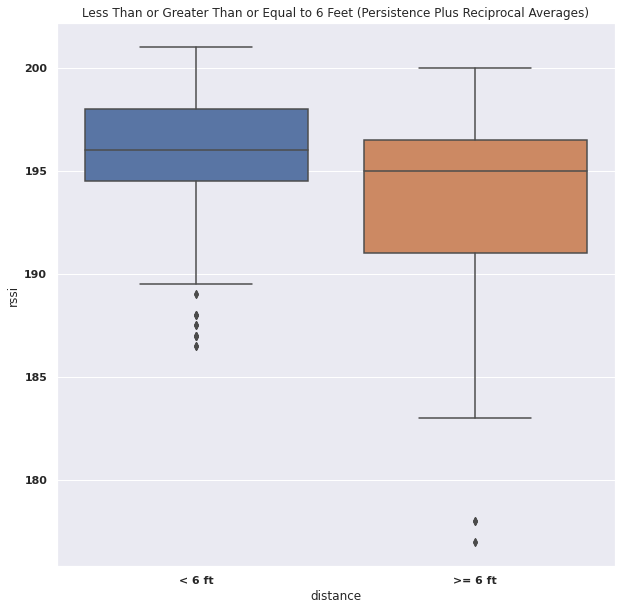

In [442]:
data = grouped_data.copy()
data["distance"][data["distance"] < 72] = 71
data["distance"][data["distance"] >= 72] = 72
sns.set(font_scale=1)
ax = sns.boxplot(x="distance", y="rssi", data=data).set_xticklabels(["< 6 ft", ">= 6 ft"])
plt.title("Less Than or Greater Than or Equal to 6 Feet (Persistence Plus Reciprocal Averages)")
sns.set(rc={"figure.figsize":(10,10)})
plt.savefig("Distance_Division_Persistence_Averages_2.png", dpi = 500)

**Density Plots**

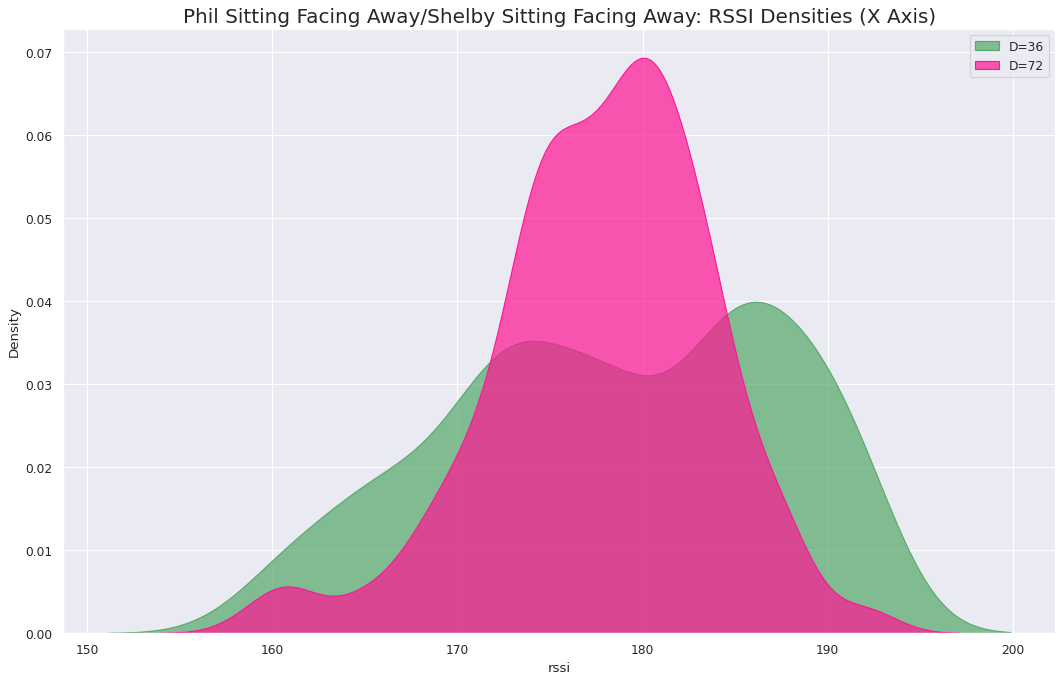

In [103]:
#data = truth_data[((truth_data["p1annotation"] == 'Phil-sitting; facing') | (truth_data["p1annotation"] == 'Phil-sitting; facing ')) & ((truth_data["p2annotation"] == 'Shelby-sitting; facing') | (truth_data["p2annotation"] == 'Shelby-sitting; facing '))]
data = truth_data[(truth_data["p1annotation"] == 'Phil-sitting; facing away') & (truth_data["p2annotation"] == 'Shelby-sitting; facing away')]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data.loc[data["distance"] == 36, "rssi"], shade=True, color="g", label="D=36", alpha=.7)
sns.kdeplot(data.loc[data["distance"] == 72, "rssi"], shade=True, color="deeppink", label="D=72", alpha=.7)
#sns.kdeplot(data.loc[data["distance"] == 60, "rssi"], shade=True, color="dodgerblue", label="D=60", alpha=.7)
#sns.kdeplot(data.loc[data["distance"] == 84, "rssi"], shade=True, color="orange", label="D=84", alpha=.7)
#sns.kdeplot(data.loc[data["distance"] == 120, "rssi"], shade=True, color="red", label="D=120", alpha=.7)

plt.title("Phil Sitting Facing Away/Shelby Sitting Facing Away: RSSI Densities (X Axis)", fontsize=18)
plt.legend()
#plt.show()
plt.savefig('Sitting_Facing_Away_Density.png', dpi = 500)

#-------------------------------------------------------------------------------------------------------------------------

#data = truth_data[(truth_data["p1annotation"] == "Phil-facing") & (truth_data["p2annotation"] == "Shelby-facing")]

#plt.figure(figsize=(16,10), dpi= 80)
#fig, axes = joypy.joyplot(data, column=["rssi"], by="distance", figsize=(14,10), colormap=cm.autumn_r)

# Decoration
#plt.title("Phil Standing Facing/Shelby Standing Facing: RSSI Densities (X Axis) and Distances (Y Axis)", fontsize=22)
#plt.show()

**Time Series Plots**

The number of different distances in inches are: [36, 72, 96, 120]


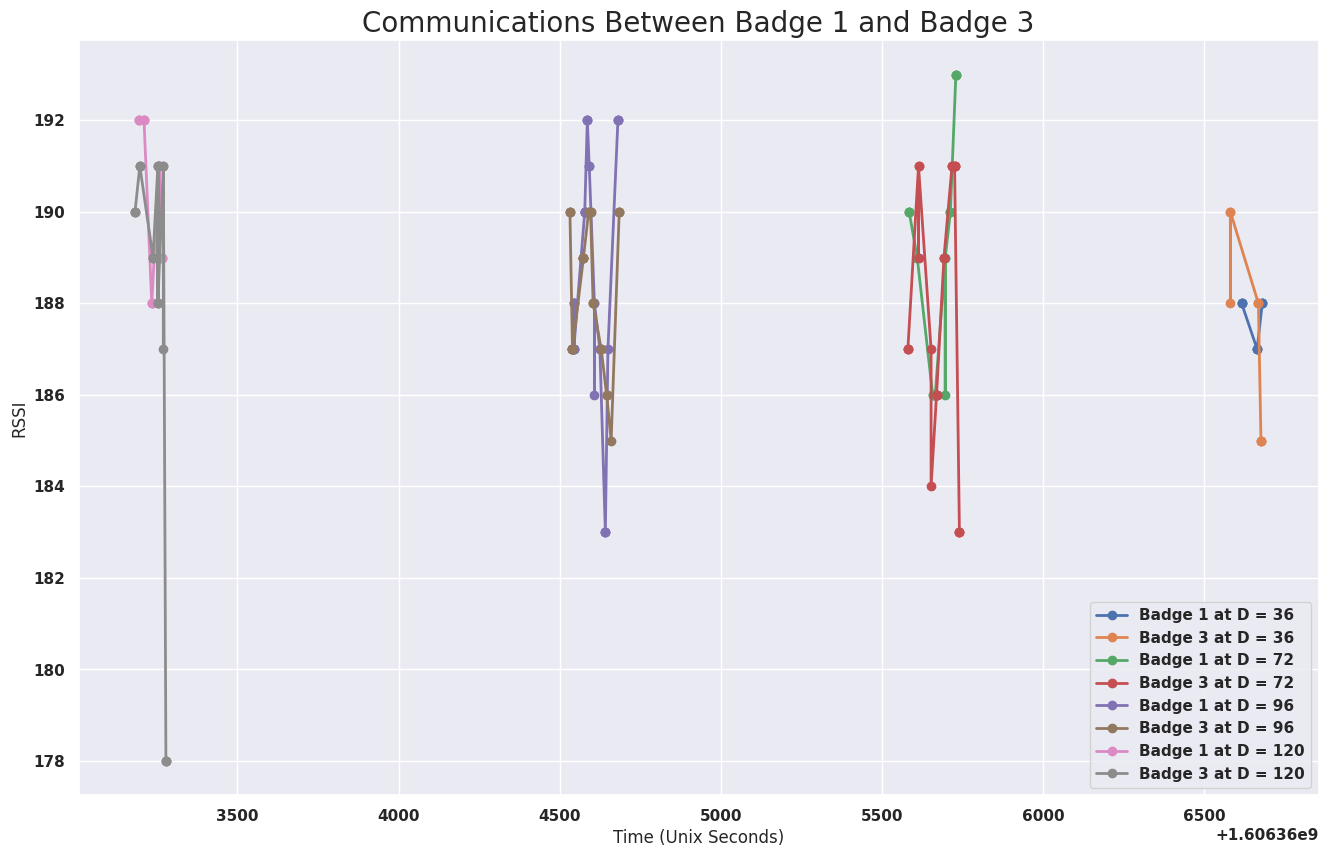

In [443]:
person_badge_pairs = [[1, 2], [3, 4], [5, 6], [8, 9], [4, 5]]
nonpairs = [[1, 3], [1, 4], [2, 3], [2, 4], [5, 8], [5, 9], [6, 8], [6, 9], [1, 4], [1, 5], [2, 4], [2, 5]]

time_series = data_to_plot.copy()
time_series_one = time_series[(time_series["sending_badge"] == nonpairs[0][0]) & (time_series["receiving_badge"] == nonpairs[0][1])]
time_series_two = time_series[(time_series["sending_badge"] == nonpairs[0][1]) & (time_series["receiving_badge"] == nonpairs[0][0])]

distance_vals = sorted(list(set(time_series_one["distance"])))
print("The number of different distances in inches are:", distance_vals)

plt.figure(figsize=(16,10), dpi= 100)
font = {'weight' : 'bold', 'size' : 40}
plt.rc('font', **font)
    
for i in range(len(distance_vals)):
    
    time_series_points_one = time_series_one[time_series_one["distance"] == distance_vals[i]]
    time_series_points_two = time_series_two[time_series_two["distance"] == distance_vals[i]]

    rssi_vals_one   = list(time_series_points_one["rssi"])
    time_vals_one   = list(time_series_points_one["unix_times"])
    rssi_vals_two   = list(time_series_points_two["rssi"])
    time_vals_two   = list(time_series_points_two["unix_times"])

    plt.plot(time_vals_one, rssi_vals_one, "-o", label = "Badge 1 at D = " + str(distance_vals[i]), linewidth=2)
    plt.plot(time_vals_two, rssi_vals_two, "-o", label = "Badge 3 at D = " + str(distance_vals[i]), linewidth=2)

plt.legend()
plt.xlabel("Time (Unix Seconds)")
plt.ylabel("RSSI")
plt.title("Communications Between Badge 1 and Badge 3", fontsize = 20)
plt.savefig("Time_Series.png", dpi = 500)
plt.show()

**Here Is a Table Displaying Statistics of Grouped RSSI Values**

In [133]:
grouped_data    = truth_data.copy()

rssi_stats   = grouped_data.groupby(["sending_badge", "receiving_badge", "distance", "p1badge1_loc", "p1badge2_loc", 
                                    "p2badge1_loc", "p2badge2_loc", 
                                    "p1annotation", "p2annotation"], as_index=False).agg({'rssi': ['mean', 'min', 'max', 'median']})

rssi_stats.columns = rssi_stats.columns.get_level_values(0)

rssi_stats.columns.values[-4] = "rssi_mean"
rssi_stats.columns.values[-3] = "rssi_min"
rssi_stats.columns.values[-2] = "rssi_max"
rssi_stats.columns.values[-1] = "rssi_median"
rssi_stats = rssi_stats.reset_index(drop = True)
rssi_stats = rssi_stats.sort_values(by="rssi_mean", inplace=False, ascending=False)
del rssi_stats["index"]

#mean_rssi.to_csv("D:/Hospital Networking/Mean_RSSI.csv", index=False)  

#rssi_stats

## Truth Data Machine Learning with XGBOOST
## =============================================================

In [56]:
truth_data_one_hot = pd.get_dummies(truth_data, columns=["p1badge1_loc", "annotation", "p1badge2_loc", "p1annotation",
                                                        "p2badge1_loc", "p2badge2_loc", "p2annotation"])

D = truth_data_one_hot.pop("distance")
truth_data_one_hot["distance"] = D
truth_data_one_hot

,rssi,anchor,sending_badge,receiving_badge,p1badge1_loc_left lapel,p1badge1_loc_left lapel with battery back,p1badge2_loc_left hip with battery back,p1badge2_loc_right lapel,p1annotation_Phil-L shoulder facing,p1annotation_Phil-R shoulder facing,p1annotation_Phil-facing,p1annotation_Phil-facing,p1annotation_Phil-facing away,p1annotation_Phil-sitting at table with plexiglass; L shoulder facing,p1annotation_Phil-sitting at table with plexiglass; facing,p1annotation_Phil-sitting at table with plexiglass; staggered,p1annotation_Phil-sitting at table without plexiglass; L shoulder facing,p1annotation_Phil-sitting facing,p1annotation_Phil-sitting; L shoulder facing,p1annotation_Phil-sitting; facing,p1annotation_Phil-sitting; facing,p1annotation_Phil-sitting; facing away,p1annotation_Phil-sitting; staggered facing,p1annotation_Phil-walking,p2badge1_loc_left lapel,p2badge1_loc_left lapel with battery back,p2badge2_loc_left hip with battery back,p2badge2_loc_right lapel,p2annotation_Shelby-L shoulder facing,p2annotation_Shelby-R shoulder facing,p2annotation_Shelby-facing,p2annotation_Shelby-facing away,p2annotation_Shelby-sitting at table with outplexiglass; R shoulder facing,p2annotation_Shelby-sitting at table with plexiglass; R shoulder facing,p2annotation_Shelby-sitting at table with plexiglass; facing,p2annotation_Shelby-sitting at table with plexiglass; staggered,p2annotation_Shelby-sitting facing,p2annotation_Shelby-sitting; R shoulder facing,p2annotation_Shelby-sitting; facing,p2annotation_Shelby-sitting; facing,p2annotation_Shelby-sitting; facing away,p2annotation_Shelby-sitting; staggered facing,p2annotation_Shelby-walking,distance
1,195,1024,2,4,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,120
3,195,1026,2,4,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,120
5,195,1029,2,4,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,120
7,193,1024,4,2,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,120
9,193,1026,4,2,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60751,198,1029,8,6,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,240
60753,197,1024,6,8,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,240
60754,194,1024,6,7,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,240
60756,197,1029,6,8,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,240


In [45]:
dataset = truth_data_one_hot.to_numpy()
print(dataset.shape)
X = dataset[:, 0:3]
Y = dataset[:, -1]

(33790, 4)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=7)
model = xgb.XGBClassifier(verbosity=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Kfold Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 34.54%
Kfold Accuracy: 11.34% (9.56%)


In [58]:
rcParams['figure.figsize'] = 12, 4

train = truth_data_one_hot
target = 'distance'
IDcol = 'anchor'

#train = pd.read_csv('D:/Hospital Networking/train_modified.csv')
#target = 'Disbursed'
#IDcol = 'ID'

In [50]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['distance'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['distance'].values, dtrain_predictions))
    #print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['distance'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return dtrain_predictions


Model Report
Accuracy : 0.6778


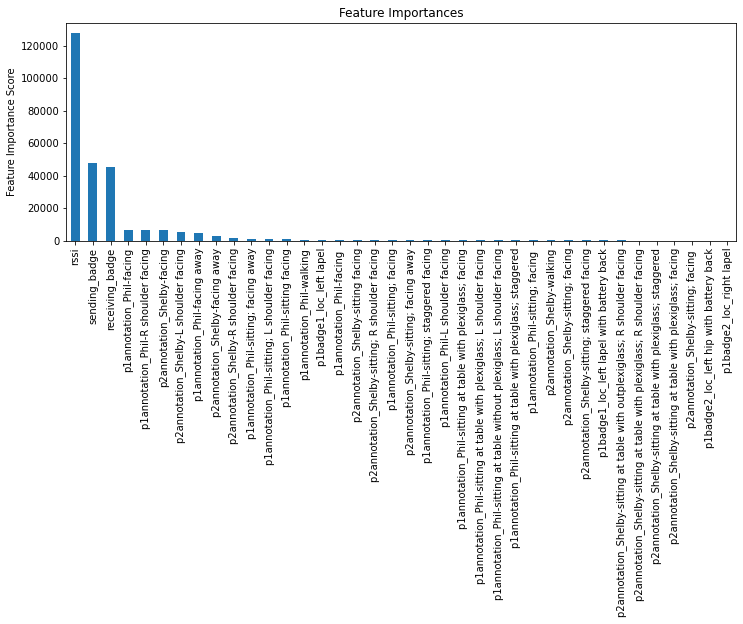

In [59]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

predictions = modelfit(xgb1, train, predictors)